# Candidates in Hydro Simulations
In this notebook we take the Illustris-1 simulation volume to find Local Group candidates.

Usually these candidates are found using the dark matter information. 
In this notebook we take a different approach by selecting them based on the baryonic information.

Our candidates are thus pairs selected based on the stellar masses.

1. They are composed by two galaxies $G_A$ and $G_B$.
2. $G_A$ and $G_B$ belong to the set of dark matter halos $S_{1}$; $S_{1}$ contains all subhalos with stellar mass content  $1.0\times 10^{10}$ M$_{\odot}<M_s < 1.0\times 10^{11}$ M$_{\odot}$ (http://adsabs.harvard.edu//abs/2013AAS...22125411L, http://arxiv.org/abs/1410.0017)
3. The distance between $H_A$ and $H_B$ is less than 1500 kpc and larger than 500 kpc.
4. $H_A$ and $H_B$ are mutually its nearest halos in the set $S_{1}$.
5. Within 1800 kpc there are not any subhalos with stellar masses larger than the lower stellar mass galaxy in the pair.

We now proceed to build such sample.

In [77]:
%pylab inline
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors

Populating the interactive namespace from numpy and matplotlib


In [78]:
basePath = "/hpcfs/home/ciencias/fisica/docentes/je.forero/Illustris-1/"
hubble = 0.704

In [79]:
#halos = gc.loadHalos(basePath,135)
#subhalos = gc.loadSubhalos(basePath,135)
#header = gc.loadHeader(basePath,135)
#BoxSize = header['BoxSize']

halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,135, fields=halo_fields) # the selection is based on the FOF groups

subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVmax','SubhaloMassType',
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
subhalos = gc.loadSubhalos(basePath,135, fields=subhalo_fields)
header = gc.loadHeader(basePath,135)
BoxSize = header['BoxSize']

In [80]:
print(halos.keys())
print(subhalos.keys())

dict_keys(['GroupMassType', 'Group_M_Mean200', 'GroupNsubs', 'GroupVel', 'Group_R_Crit200', 'GroupPos', 'Group_M_Crit200', 'GroupFirstSub', 'count'])
dict_keys(['SubhaloSFRinRad', 'SubhaloVel', 'SubhaloGrNr', 'SubhaloMassType', 'SubhaloMass', 'SubhaloVmax', 'SubhaloParent', 'SubhaloPos', 'SubhaloStellarPhotometrics', 'count'])


In [81]:
#mases are: Gas, DM, unused, tracers, stars+wind particles, black holes
halo_masses = halos['GroupMassType']
halo_M_crit200 = halos['Group_M_Mean200']
halo_pos = halos['GroupPos']
halo_vel = halos['GroupVel']
halo_stellar_mass = halo_masses[:,4]

subhalo_masses = subhalos['SubhaloMassType']
subhalo_pos = subhalos['SubhaloPos']
subhalo_mags = subhalos['SubhaloStellarPhotometrics']
subhalo_vmax = subhalos['SubhaloVmax']
subhalo_parent_fof = subhalos['SubhaloGrNr']
subhalo_stellar_mass = subhalo_masses[:,4]
print(shape(subhalo_vmax))

(4366546,)


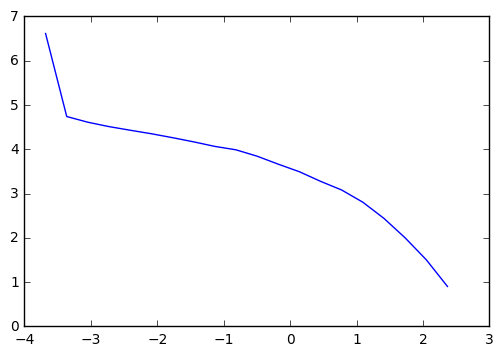

In [82]:
vals, edges = histogram(log10(subhalo_stellar_mass+1E-4), bins=20)
plot(edges[1:], log10(vals))

In [83]:
index_S = where(subhalo_stellar_mass/hubble>1.0)
n_S = size(index_S)
print("size subset: %d halos"%(n_S))

size subset: 6947 halos


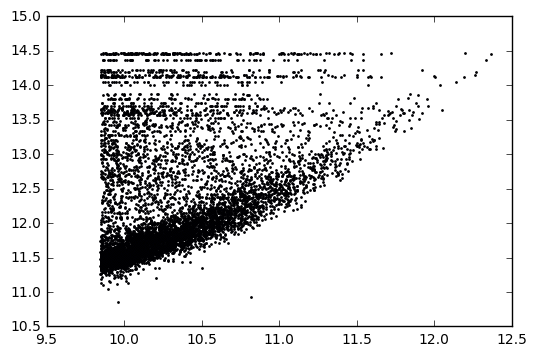

In [84]:
scatter(log10(subhalo_stellar_mass[index_S])+10, 
        log10(halo_M_crit200[subhalo_parent_fof[index_S]]+1E-1)+10, s=1.0)

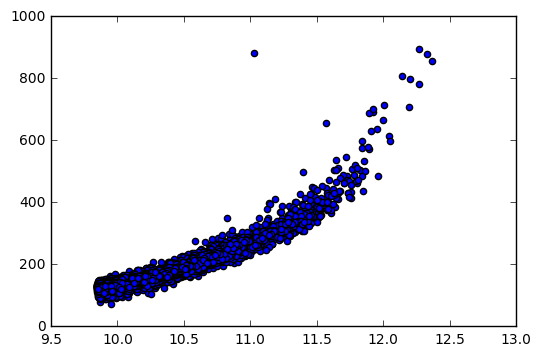

In [85]:
scatter(log10(subhalo_stellar_mass[index_S])+10, subhalo_vmax[index_S])

In [86]:
S_pos = subhalos['SubhaloPos'][index_S]
S_vel = subhalos['SubhaloVel'][index_S]
S_vmax = subhalos['SubhaloVmax'][index_S]
S_stellar_mass = subhalo_stellar_mass[index_S]
S_parent_fof = subhalo_parent_fof[index_S]

In [87]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S_pad_pos = S_pos.copy()
S_pad_vel = S_vel.copy()
S_pad_vmax = S_vmax.copy()
S_pad_stellar_mass = S_stellar_mass.copy()
S_pad_fof = S_parent_fof.copy()
S_pad_id = arange(n_S)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S_pad_pos = append(S_pad_pos, new_pos, axis=0)
                S_pad_vel = append(S_pad_vel, S_vel, axis=0)
                S_pad_vmax = append(S_pad_vmax, S_vmax)
                S_pad_stellar_mass = append(S_pad_stellar_mass, S_stellar_mass)
                S_pad_id = append(S_pad_id, arange(n_S))
                S_pad_fof = append(S_pad_fof, S_parent_fof)

In [88]:
nbrs_S = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S_pad_pos)
dist_S, ind_S = nbrs_S.kneighbors(S_pad_pos)
print(S_pad_pos.shape)
print(dist_S.shape)

(187569, 3)
(187569, 20)


In [89]:
neighbor_index = ind_S[:,1]
neighbor_list = ind_S[:,2:]
print(shape(neighbor_list))

n_pairs = 0

halo_A_id = empty((0), dtype=int)
halo_B_id = empty((0), dtype=int)

for i in range(n_S):
    l = neighbor_index[neighbor_index[i]]% n_S
    j = neighbor_index[i] % n_S
    
    other_j = neighbor_list[i,:] % n_S
    other_l = neighbor_list[neighbor_index[i],:] % n_S
    
    if((i==l) & (not (j in halo_A_id)) & (not (i in halo_B_id))): # first check to find mutual neighbors
        if((dist_S[i,1]/hubble > 700.0)): #third check on the distance between the two galaxies
            stellar_mass_i = S_pad_stellar_mass[i]
            stellar_mass_j = S_pad_stellar_mass[j]
            mass_limit = min([stellar_mass_i, stellar_mass_j])
                
            pair_d = dist_S[i,1] # This is the current pair distance
            dist_limit = pair_d * 3.0
                
            massive_close_to_i = any((dist_S[i,2:]<dist_limit) & (S_pad_stellar_mass[other_j] >= mass_limit))
            massive_close_to_j = any((dist_S[j,2:]<dist_limit) & (S_pad_stellar_mass[other_l] >= mass_limit))
            if((not massive_close_to_i) & (not massive_close_to_j)):
                n_pairs = n_pairs+ 1
                halo_A_id = append(halo_A_id, int(i))
                halo_B_id = append(halo_B_id, int(j))
                    #print(pair_d)
print(n_pairs)

(187569, 18)
136


In [108]:
halo_A = np.array([S_pad_fof[halo_A_id], halo_M_crit200[halo_A_id], halo_pos[halo_B_id,0], halo_vel[halo_A_id,0]])
savetxt('data_halo_A.txt', halo_A.T)
#print(halo_A)
#print(halo_pos[45,0])

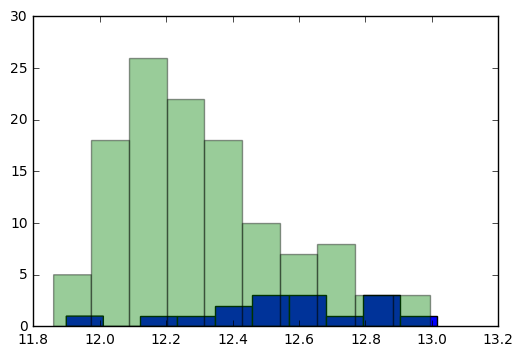

In [90]:
ii = S_pad_fof[halo_A_id]==S_pad_fof[halo_B_id]
#print(ii, S_pad_parent_fof[halo_A_id[ii]])
same_parent = S_pad_fof[halo_A_id[ii]]
diff_parent_A = S_pad_fof[halo_A_id[~ii]]
diff_parent_B = S_pad_fof[halo_B_id[~ii]]
a = plt.hist(log10(halo_M_crit200[same_parent]/hubble)+10.0)
a = plt.hist(log10(halo_M_crit200[diff_parent_A]*1E10/hubble + halo_M_crit200[diff_parent_B]*1E10/hubble), alpha=0.4)

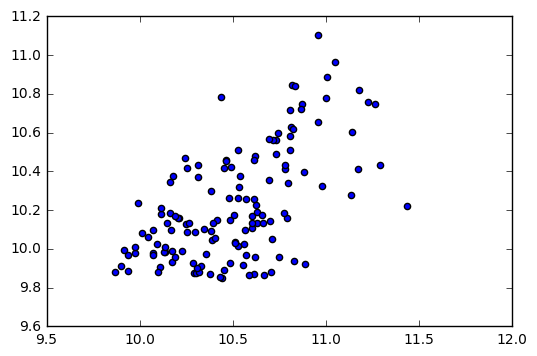

In [68]:
plt.scatter(np.log10(S_stellar_mass[halo_A_id])+10.0, np.log10(S_stellar_mass[halo_B_id]) + 10.0)

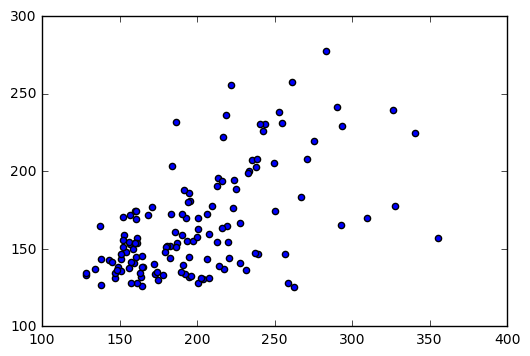

In [69]:
plt.scatter(S_vmax[halo_A_id], S_vmax[halo_B_id])

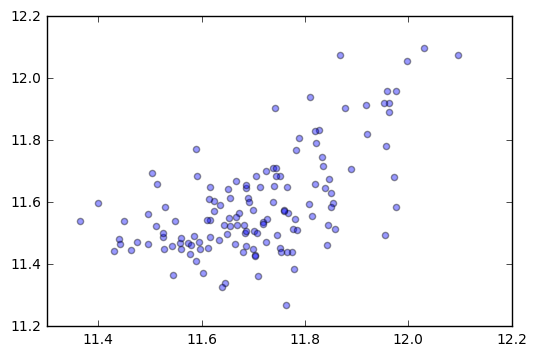

In [70]:
plt.scatter(log10(halo_M_crit200[halo_A_id]*1E10/hubble), 
            log10(halo_M_crit200[halo_B_id]*1E10/hubble), alpha=0.4)

In [71]:
index_S = where((halo_M_crit200*1E10/hubble>1.0E11))
n_S = size(index_S)
print("size subset: %d halos"%(n_S))

size subset: 17828 halos


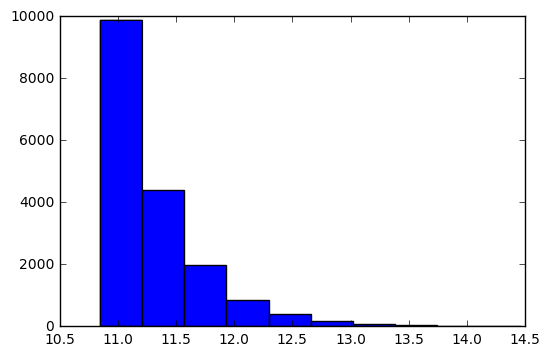

In [72]:
a = plt.hist(np.log10(halo_M_crit200[index_S]*1E10 + 1))

In [73]:
S_pos = halos['GroupPos'][index_S]
S_vel = halos['GroupVel'][index_S]
S_halo_mass = halos['Group_M_Mean200'][index_S]
S_stellar_mass = halo_stellar_mass[index_S]
fof_indexes = arange(len(halos['GroupPos']))
S_parent_fof = fof_indexes[index_S]

In [74]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S_pad_pos = S_pos.copy()
S_pad_vel = S_vel.copy()
S_pad_stellar_mass = S_stellar_mass.copy()
S_pad_halo_mass = S_halo_mass.copy()
S_pad_fof = S_parent_fof.copy()
S_pad_id = arange(n_S)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S_pad_pos = append(S_pad_pos, new_pos, axis=0)
                S_pad_vel = append(S_pad_vel, S_vel, axis=0)
                S_pad_stellar_mass = append(S_pad_stellar_mass, S_stellar_mass)
                S_pad_halo_mass = append(S_pad_halo_mass, S_halo_mass)
                S_pad_id = append(S_pad_id, arange(n_S))
                S_pad_fof = append(S_pad_fof, S_parent_fof)

In [75]:
nbrs_S = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S_pad_pos)
dist_S, ind_S = nbrs_S.kneighbors(S_pad_pos)
print(S_pad_pos.shape)
print(dist_S.shape)

(481356, 3)
(481356, 20)


In [76]:
neighbor_index = ind_S[:,1]
neighbor_list = ind_S[:,2:]
print(shape(neighbor_list))

n_pairs = 0

halo_A_id = empty((0), dtype=int)
halo_B_id = empty((0), dtype=int)

for i in range(n_S):
    l = neighbor_index[neighbor_index[i]]% n_S
    j = neighbor_index[i] % n_S
    
    other_j = neighbor_list[i,:] % n_S
    other_l = neighbor_list[neighbor_index[i],:] % n_S
    
    if((i==l) & (not (j in halo_A_id)) & (not (i in halo_B_id))): # first check to find mutual neighbors
        if((dist_S[i,1]/hubble>(700.0))): #third check on the distance between the two galaxies
            halo_mass_i = S_pad_halo_mass[i]
            halo_mass_j = S_pad_halo_mass[j]
            mass_limit = min([halo_mass_i, halo_mass_j])
                
            pair_d = dist_S[i,1] # This is the current pair distance
            dist_limit = pair_d * 3.0
                
            massive_close_to_i = any((dist_S[i,2:]<dist_limit) & (S_pad_halo_mass[other_j] >= mass_limit))
            massive_close_to_j = any((dist_S[j,2:]<dist_limit) & (S_pad_halo_mass[other_l] >= mass_limit))
            if((not massive_close_to_i) & (not massive_close_to_j)):
                n_pairs = n_pairs+ 1
                halo_A_id = append(halo_A_id, int(i))
                halo_B_id = append(halo_B_id, int(j))
print(n_pairs)

(481356, 18)
298


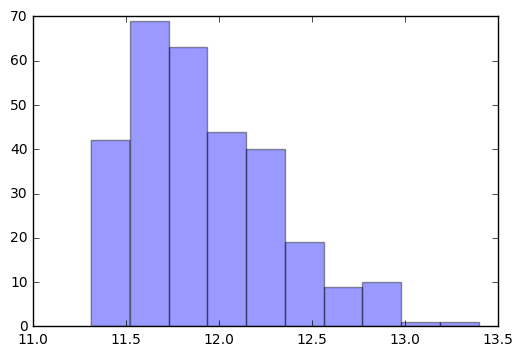

In [51]:
a = plt.hist(log10(halo_M_crit200[halo_A_id]*1E10/hubble + halo_M_crit200[halo_B_id]*1E10/hubble), alpha=0.4)

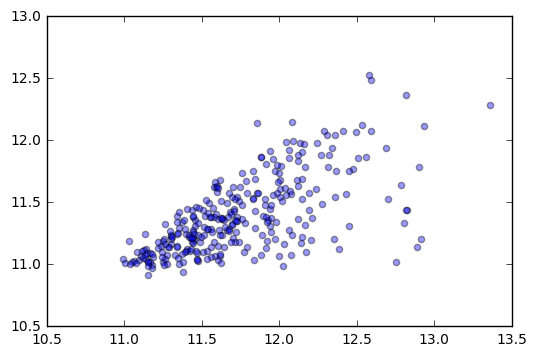

In [53]:
plt.scatter(log10(halo_M_crit200[halo_A_id]*1E10/hubble), log10(halo_M_crit200[halo_B_id]*1E10/hubble), alpha=0.4)